Het maken van de dif_batches
-
Om met behulp van PCA anomalieën te detecteren in peniciline productie worden er vier stappen gezet.

1. Het maken van een NOC_batch
2. Het maken van de dif_batches
3. Het uitvoeren van de PCA
4. Het classificeren van de data

Deze stappen komen rechtstreeks uit een eerder opgesteld document om de werking van PCA uit te leggen en hoe PCA toe te passen in ons project. Dit document is meegestuurd in de bijlage.

In dit jupyter notebook wordt de vierde stap uitgevoerd, classificeren vande data. Op basis van de dif_batches of de pooled_batches wordt doormiddel van PCA de data geclassificeerd. Dit wordt gedaan door het terugbrengen van de dimenties d.m.v. PCA, net zoals bij PCA_plotting. Hierna wordt d.m.v. PCA weer terug gewerkt naar het orspronkelijke aantal dimenties. Hierdoor wordt de meest omschrijvende gedeelte van de data onthouden en vallen anomalieën extra op. 

het classificeren gebeurd aan de hand van de loss. Dit is de hoeveelheid informatie die verloren is gegaan door een batch door deze PCA heen te halen. De foutieve batches, zouden meer loss moeten hebben dan de goede batches.

Van de loss wordt een mediaan en een standaardafwijking berekent. Aan de hand van deze waarden wordt een optimale grens bepaald. 

Voor dit jupyter notebook is er gebruik gemaakt van een pooled_batches dataframe. Hierin staan de dif_batches gepooled in pools van 20 timestamps. Meer informatie over deze dataframe staat in de jupyter notebook 'pooled_batches'. 

De manier van PCA gebruiken om de batches te classificeren is afgeleid van de volgende bron: J. Prosise, “PCA-Based Anomaly Detection,” Atmosera, Aug. 10, 2021. [Online]. Available: https://www.atmosera.com/blog/pca-based-anomaly-detection/. [Accessed: Nov. 01, 2022]

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = [25, 5]

pooled_batches = pd.read_csv(r'pooled_batches_20.csv')
pooled_batches

,Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),...,Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Batch_id,Timestamp,Faulty
0,0.0,0.0,4.906304,238.571317,500.534273,506.546440,0.0,2.220446e-15,0.0,0.975620,...,5787.495292,0.027719,0.000000,0.0,0.842884,0.010536,0.0,1.0,20.0,False
1,0.0,0.0,0.000000,157.845736,150.154679,4.235639,0.0,2.220446e-15,0.0,1.116864,...,6177.755671,0.025026,0.000000,0.0,0.267870,0.009534,0.0,1.0,40.0,False
2,0.0,0.0,0.444484,241.161600,740.100214,77.168623,0.0,2.220446e-15,0.0,1.496355,...,6500.554242,0.135286,0.000000,0.0,1.424782,0.072152,0.0,1.0,60.0,False
3,0.0,0.0,0.556081,294.064500,1670.234786,491.573895,0.0,2.220446e-16,0.0,3.224266,...,5820.736726,0.129764,0.000000,0.0,1.972338,0.069250,0.0,1.0,80.0,False
4,0.0,0.0,0.111287,750.622643,2333.650357,82.388586,0.0,0.000000e+00,0.0,0.095226,...,5901.126143,0.555931,0.000000,0.0,2.787246,0.296856,0.0,1.0,100.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,0.0,0.0,0.000000,1196.689486,507.313802,848.203797,0.0,4.440892e-15,0.0,1050.596005,...,888.675571,5.751943,38.370829,0.0,11.804550,5.514436,0.0,100.0,920.0,True
4268,0.0,0.0,0.000000,1168.727657,518.306181,786.909263,0.0,4.440892e-15,0.0,1091.870130,...,787.526286,5.949650,38.056557,0.0,11.574139,5.703707,0.0,100.0,940.0,True
4269,0.0,0.0,14.340592,906.293870,521.778182,880.711718,0.0,4.440892e-15,0.0,1135.677933,...,703.240857,6.052743,37.325971,0.0,13.667070,5.801200,0.0,100.0,960.0,True
4270,0.0,0.0,19.817549,1217.744737,557.600130,856.184106,0.0,4.440892e-15,0.0,1181.287104,...,835.557429,6.011971,47.212393,0.0,13.447560,5.758729,0.0,100.0,980.0,True


In de cel hieronder worden de laatste dingen gedaan voor het uitvoeren van de PCA. 
- Alleereerst wordt de data gescaled doormiddel van de standardscaler van sklearn. 
- Hierna worden de pools verdeeld in twee groepen de foutieve en de goede. Dit is belangrijk omdat de PCA alleen moet leren op de goede batches en niet de foutieve. 
- De pools in zowel de goede als de foute batches worden op een random volgorde geplaatst d.m.v. de sample() functie met een frac van 1. dit is voornamelijk belangrijk voor de goede pools omdat de PCA hier beter van leerd. 
- Als laatste worden de kolommen 'Batch_id', 'Timestamp' en 'Faulty' uit de dataframes gehaald omdat dit geen data is die de PCA in moet maar enkel gebruikt wordt om de pools later nog te kunnen herkennen.

In [61]:
scaler = StandardScaler()
scaler.fit(pooled_batches.iloc[:,:len(pooled_batches.columns)-3])

original_legit = pooled_batches[pooled_batches['Faulty'] == 0]
original_faulty = pooled_batches[pooled_batches['Faulty'] == 1]

original_legit = original_legit.sample(frac=1)
original_faulty = original_faulty.sample(frac=1)

original_legit = original_legit.drop(['Batch_id', 'Timestamp', 'Faulty'], axis=1)
original_faulty = original_faulty.drop(['Batch_id', 'Timestamp', 'Faulty'], axis=1)

legit = scaler.transform(original_legit)
faulty = scaler.transform(original_faulty)
 


In de cel hieronder wordt daadwerkelijk de PCA uitgevoerd. Na offline wat testen te doen om een goed aantal componenten voor de PCA te bepalen, is ervoor gekozen om met de PCA terug te werken naar 10 componeneten. Het aantal componenten had niet heel erg veel invloed op het resultaat maar 10 leek het wel aardig te doen. In de toekomst zou ervoor gekozen kunnen worden om  deze waarde wat de optimaliseren. 

Zoals eerder gesteld wordt de PCA getraint op de goede batches en uitgevoerd op zowel de goede als foute batches. Van daar de fit_transform() bij de goede batches en alleen een transform bij de foute batches. Hierna worden beide soorten batches weer terug ge transformeerd naar 21 features.

In [62]:
pca = PCA(n_components=10, random_state=0)
legit_pca = pd.DataFrame(pca.fit_transform(legit), index=original_legit.index)
faulty_pca = pd.DataFrame(pca.transform(faulty), index=original_faulty.index)
 
legit_restored = pd.DataFrame(pca.inverse_transform(legit_pca))
faulty_restored = pd.DataFrame(pca.inverse_transform(faulty_pca))

In de volgende cel worden de losses van alle pools bepaald. In de plot worden alle losses geprint. De groene stippen zijn pools van goede batches en de rode stippen zijn pools van foutieve batches. Het verschil in loss lijkt minimaal of zelfs niet bestaand. Toch ligt de loss bij de foutieve batches iets hoger.

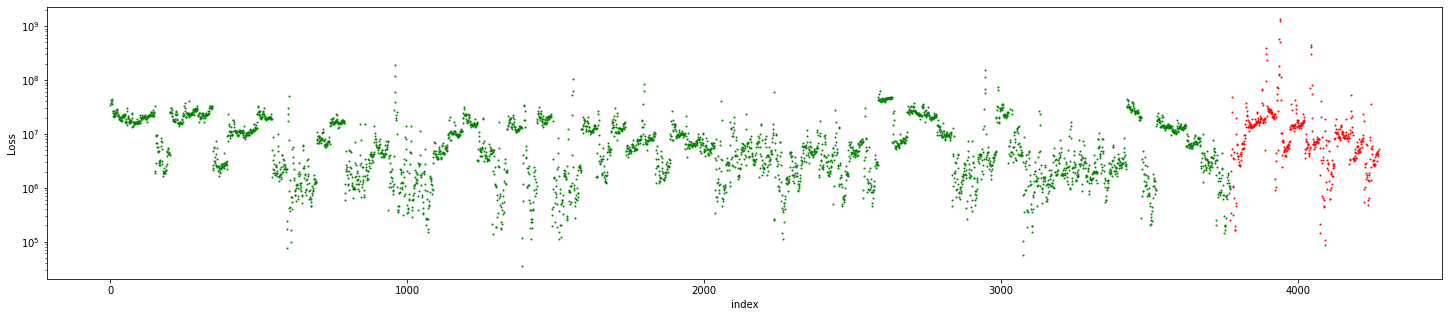

In [63]:

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss
 
legit_scores = get_anomaly_scores(original_legit, legit_restored)
faulty_scores = get_anomaly_scores(original_faulty, faulty_restored)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Loss')
ax.set_xlabel('index')

plt.yscale("log")

ax.scatter(legit_scores.index,legit_scores,  s=1, c='g')
ax.scatter(faulty_scores.index,faulty_scores,s=1, c='r')

In deze cel worden mu en sigma uitgerekent van de loss waarden van de goede batches, de foutieve batches en alle batches bij elkaar. hiermee wordt in de volgende cel een optimale grens bepaald om de batches mee te classificeren. 

In [64]:
mu_legit = sum(legit_scores)//len(legit_scores)
mu_faulty = sum(faulty_scores)//len(faulty_scores)
mu_total = (sum(faulty_scores) + sum(legit_scores))//(len(faulty_scores) + len(legit_scores))

print(f"{int(mu_legit):,}",' ,',f"{int(mu_faulty):,}",',',f"{int(mu_total):,}")

sigma_legit = 0
for score in legit_scores:
    sigma_legit += (score-mu_legit)**2
sigma_legit = (sigma_legit//len(legit_scores))**0.5

sigma_faulty = 0
for score in faulty_scores:
    sigma_faulty += (score-mu_faulty)**2
sigma_faulty = (sigma_faulty//len(faulty_scores))**0.5

sigma_total = 0
for score in faulty_scores:
    sigma_total += (score-mu_total)**2
for score in legit_scores:
    sigma_total += (score-mu_total)**2
sigma_total = (sigma_total//(len(faulty_scores)+len(legit_scores)))**0.5

print(f"{int(sigma_legit):,}",',',f"{int(sigma_faulty):,}",',',f"{int(sigma_total):,}")

9,264,483  , 23,860,355 , 10,972,801
10,818,233 , 96,234,602 , 34,774,739


In de cel hieronder wordt een functie gedefineerd om de predictions te kunnen checken tegen de daadwerkelijke waarden. De functie neemd als input een lijst met daarin alle predictions: [prediction1 , prediction2 , etc...] en geeft het aantal batches in de categorieën: true positive, false positive, false negative en true negative terug. Elke batch wordt in één categorie ingedeeld waardoor de aantal outputs gelijk moet staan aan het aantal batches, wat in dit geval 86 is. 

Een batch wordt als positief/foutief gezien als één of meerdere pools uit deze batch als positief/foutief wordt gelabeld. Enkel als alle pools van een batch als negatief/goed worden gelabeld wordt de batch dat ook.

In [65]:
def check_predictions(predictions):
    tp = []
    tn = []
    fn = []
    fp = []
    for i in predictions:
        x = True
        if i[1] == True and pooled_batches.at[i[0],'Faulty'] == True:
            for ii in tp:
                if pooled_batches.at[i[0],'Batch_id'] == ii:
                    x = False
            if x:
                tp.append(pooled_batches.at[i[0],'Batch_id'])
        elif i[1] == True and pooled_batches.at[i[0],'Faulty'] == False:
            for ii in fp:
                if pooled_batches.at[i[0],'Batch_id'] == ii:
                    x = False
            if x:
                fp.append(pooled_batches.at[i[0],'Batch_id'])
        elif i[1] == False and pooled_batches.at[i[0],'Faulty'] == True:
            for ii in fn:
                if pooled_batches.at[i[0],'Batch_id'] == ii:
                    x = False
            if x:
                fn.append(pooled_batches.at[i[0],'Batch_id'])
        elif i[1] == False and pooled_batches.at[i[0],'Faulty'] == False:
            for ii in tn:
                if pooled_batches.at[i[0],'Batch_id'] == ii:
                    x = False
            if x:
                tn.append(pooled_batches.at[i[0],'Batch_id'])
    
    for i in tp:
        try:
            fn.remove(i)
        except:
            pass
    
    for i in fp:
        try:
            tn.remove(i)
        except:
            pass


    return len(tp),len(fp),len(fn),len(tn)


In de volgende cel worden alle predictions gemaakt en gecheckt met de functie van hierboven. Dit is 6 keer gedaan, iedere keer met een andere grenswaarde. Met de uitkomst van de check_predictions() functie wordt elke keer een heatmap getekend, om het verschil tussen de verschillende grenswaarde te kunnen bekijken. 

Wat we uit de plots kunnen halen is dat:
- We alle 10 de fautieve batches kunnen onderscheiden, maar dat er hierdoor ook 42 van de goede batches als foutief gelabeld worden. 
- we 3 fautive batches kunnen onderscheiden, zonder een goede batch verkeerd te labelen. 

Dit zijn de twee extreme gevallen, maar er zit ook nog een interessante waarde tussen. Het kiezen van de beste grens zal per casus verschillen, voor deze casus zou ik willen stellen dat er gestreeft moet worden naar 0 false positives (batches labelen als fout, die eigenlijk goed waren). Hierom zou ik kiezen voor het extreme geval waarbij 3 fautieve batches kunnen worden onderscheiden en geen goede batches verkeerd gelabeld worden. op deze manier is het systeem namelijk altijd een verbetering op de oude situatie, waar niet een foutieve batch van te voren kon worden onderscheden. 

Het onderscheiden van drie batches is echter nog steeds geen topprestatie, dus zal het model nog door ontwikkeld of geoptimaliseerd moeten worden, voor betere prestaties. Hierbij kan aan een aantal factoren gedacht worden:
- Het veranderen van de poolsize. Hier is nog niet veel onderzoek naar gedaan maar kan een grote invloed hebben op de uitkomsten. Er zijn drie manieren waarop gepoold kan worden.
    1. Bij het nemen van een poolsize van 1 oftewel niet te poolen kan goed gekeken worden naar een bepaald moment maar niet over een langer termijn.
    2. Bij het nemen van een grote poolsize, zoals alle timestamps tot een bepaald moment, kan goed gekeken worden naar de verandering over een langer termijn maar juist niet op één moment.
    3. Door het verschil te berekenen tussen de huidige timestamp en één of een aantal timestamps daarvoor kan de snelheid waarmee het systeem afwijkt bekeken worden.
Tijdens dit onderzoek is gekozen om een tussenweg hierin te nemen door te poolen in batches van 20. Er is echter een betere manier om beide methoden te combineren en dat is door, letterlijk beide methode te combineren. Op deze manier gedraagd het model zich als een PID-regelaar, een veel gebruikte methode in de control engineering om fisieke systemen mee te kunnen controleren. Hierbij is optie 1 de P-regelaar, optie 2 de I-regelaar en optie 3 de D-regelaar. Samen maken zij een PID regelaar.
- Het aantal principal components waar de PCA naar toe werkt kan worden aangepast. Uit mijn ervaring heeft het aanpassen van het aantal pc's geen aanzienlijke impact op het resultaat, maar het zou kunnen zorgen voor het laatste beetje optimalisatie die het model nodig heeft.
- Er zou beter gekeken kunnen worden naar hoe de NOC_batch te construeren. Hierbij kan gedacht worden aan:
    - Het aantal en welke batches dat gebruikt worden om de NOC-batch mee te maken.
    - Naast het gemiddelde van de batches, ook een sprijdingsfactor bepalen op iedere timestamp. Hierdoor kan per moment een andere waarde gegeven worden aan een bepaalde afwijking.
    

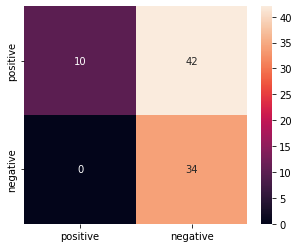

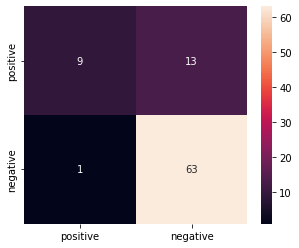

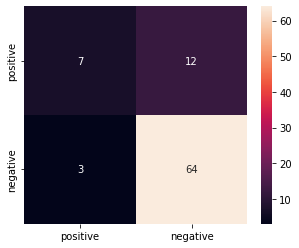

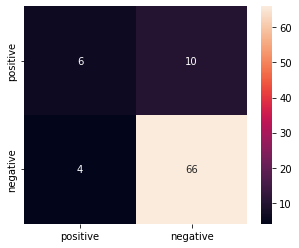

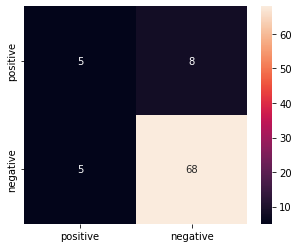

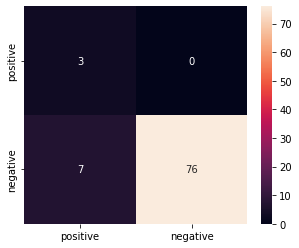

In [66]:
for i in [0.2,0.7,0.8,0.9,1,6]:
    predictions = []
    for ii in legit_scores.index:
        if legit_scores.loc[ii] > mu_total+sigma_total*i:
            predictions.append([ii,True])
        else:
            predictions.append([ii,False])

    for ii in faulty_scores.index:
        if faulty_scores.loc[ii] > mu_total+sigma_total*i:
            predictions.append([ii,True])
        else:
            predictions.append([ii,False])
    
    tp,fp,fn,tn = check_predictions(predictions)
    fig = plt.figure(figsize=(5,4))
    sns.heatmap(pd.DataFrame([[tp,fp],[fn,tn]],index=['positive','negative'],columns=('positive','negative')),annot=True)